#Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import torch
from torch import nn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms
from torchvision.transforms import ToTensor
from torchvision.models import vgg16
from torchvision.models import resnet50
import torch.optim as optim

!pip install adversarial-robustness-toolbox
from art.attacks.evasion import DeepFool as DeepFool_
from art.attacks.evasion import CarliniL2Method
from art.estimators.classification import PyTorchClassifier
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, Subset, random_split
from PIL import Image
from os import listdir
import natsort
from natsort import natsorted
from torchvision.io import read_image
from torchvision import transforms

In [ ]:
#FGSM & PGD
!pip install -qq -e git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans
import sys
sys.path.append('/content/src/cleverhans')
import cleverhans

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent


In [ ]:
!pip install adversarial-robustness-toolbox
from art.attacks.evasion import DeepFool , SaliencyMapMethod, CarliniL2Method
from art.estimators.classification import PyTorchClassifier

#Data Loader

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

!wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip
!wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip

In [ ]:
!unzip 'BelgiumTSC_Training.zip'
!unzip 'BelgiumTSC_Testing.zip'

##Dataset Class

In [ ]:
class BL_Dataset(Dataset):
    def __init__(self, Data, transform=None):
        if Data == "train":
            directory = 'Training/'
        elif Data == "test":
            directory = 'Testing/'

        folder_list = natsorted(listdir(directory))
        folder_list = folder_list[:-1]
        flist = []
        label_list = []
        for subfolder in folder_list:
          subfiles = natsorted(listdir(directory+subfolder))
          subfiles = subfiles[:-1]
          for subfile in subfiles:
            flist.append(directory+subfolder+'/'+subfile)
            label_list.append(int(subfolder))
        
        self.images = [Image.open(f) for f in flist]
        self.labels = torch.Tensor(label_list).long()

        self.transform = transform
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
         image = self.images[idx]
         label = self.labels[idx]
         if self.transform:
             image = self.transform(image)
         return image, label

In [ ]:
dataset = BL_Dataset('train', transforms.Compose([transforms.ToTensor(),
                                                 transforms.Resize((32,32))
                                                 ]))
test_dataset = BL_Dataset('test', transforms.Compose([transforms.ToTensor(),
                                                      transforms.Resize((32,32))
                                                     ]))
train_dataset, validation_dataset = random_split(dataset, [round(.80*len(dataset)),
                                                           int(.20*len(dataset))])

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=64)
validation_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=64)

##Image samples

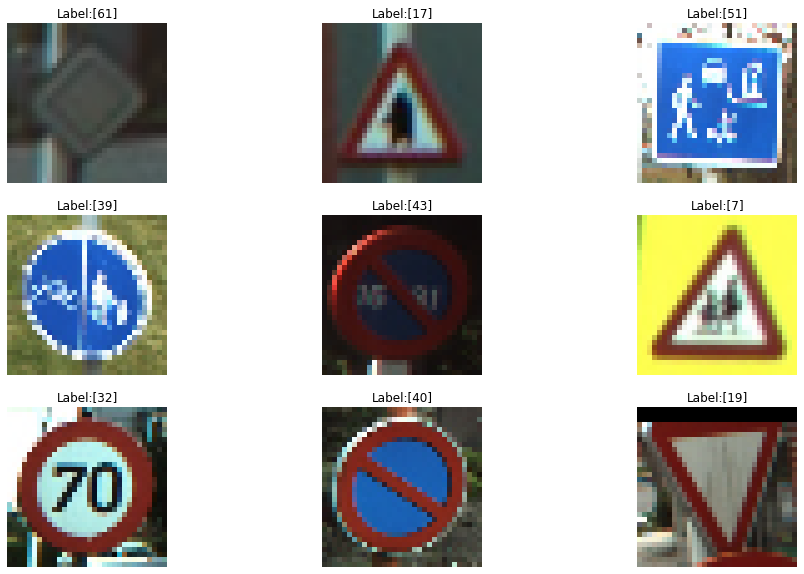

In [ ]:
plt.figure(figsize=(16, 10))
data = iter(train_dataloader)
for n in range(9):
    ax = plt.subplot(3, 3, n+1)
    image, labels = next(data)
    img = image[0].permute(1, 2, 0).squeeze()
    plt.imshow(img.numpy())
    plt.title('Label:' + str([int(labels[0])]))
    plt.axis('off')
    

# Task 1: Train two deep-learning classification models on the BTSC dataset.

##1-VGG16

In [ ]:
#VGG16
VGG16 = vgg16(pretrained=True)

In [ ]:
VGG16.classifier._modules['6'] = nn.Linear(4096, 62)

In [ ]:
VGG16.cuda()

###Train

In [ ]:
#Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGG16.parameters(), lr=0.001, momentum=0.9)

epoch_num = 10
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        
        inputs, labels = data
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = VGG16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
           
    training_loss_plot.append(running_loss)
    training_accuracy_plot.append(correct/total)

    #validation        
    running_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
      for i, data in enumerate(validation_dataloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          
          inputs, labels = data
          labels = labels.type(torch.LongTensor)
          inputs, labels = inputs.cuda(), labels.cuda()
          
          # forward 
          outputs = VGG16(inputs)
          loss = criterion(outputs, labels)

          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item() 
        
    val_loss_plot.append(running_loss)
    val_accuracy_plot.append(correct/total)
print('Finished Training')
print("validation ", val_accuracy_plot[epoch_num -1],"training", training_accuracy_plot[epoch_num-1])

In [ ]:
VGG16.eval()

###plot

In [ ]:
#VGG16 plot
plt.plot(training_loss_plot)
plt.plot(val_loss_plot)
plt.title('Training and validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()
plt.plot(training_accuracy_plot)
plt.legend(['training loss', 'validation loss'])
plt.plot(val_accuracy_plot)
plt.legend(['training accuracy', 'validation accuracy'])
plt.title('Training and validation accuracy')


###Test

In [ ]:
#Test
correct = 0
total = 0
with torch.no_grad():
  for data in test_dataloader:
      images, labels = data
      labels = labels.type(torch.LongTensor)
      images = images.cuda()
      labels = labels.cuda()
      outputs = VGG16(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %f %%' % (
100 * correct / total))

##2-ResNet50

In [ ]:
#ResNet50
ResNet50 = torchvision.models.resnet50(pretrained = True) 

In [ ]:
ResNet50._modules['6'] = nn.Linear(4096, 62)

###Train

In [ ]:
#Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNet50.parameters(), lr=0.001) #, momentum=0.9)

epoch_num = 10
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        
        inputs, labels = data
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.cuda(), labels.cuda()
        model = ResNet50

        if torch.cuda.is_available():
           model.cuda()

        optimizer.zero_grad()


        outputs = ResNet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
           
    training_loss_plot.append(running_loss)
    training_accuracy_plot.append(correct/total)

    #validation        
    running_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
      for i, data in enumerate(validation_dataloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          
          inputs, labels = data
          labels = labels.type(torch.LongTensor)
          inputs, labels = inputs.cuda(), labels.cuda()
          
          outputs = ResNet50(inputs)
          loss = criterion(outputs, labels)

          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item() 
        
    val_loss_plot.append(running_loss)
    val_accuracy_plot.append(correct/total)
print('Finished Training')
print("validation ", val_accuracy_plot[epoch_num -1],"training", training_accuracy_plot[epoch_num-1])

In [ ]:
ResNet50.eval()

###Plot

In [ ]:
#ResNet50 plot
plt.plot(training_loss_plot)
plt.plot(val_loss_plot)
plt.title('Training and validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()
plt.plot(training_accuracy_plot)
plt.legend(['training loss', 'validation loss'])
plt.plot(val_accuracy_plot)
plt.legend(['training accuracy', 'validation accuracy'])
plt.title('Training and validation accuracy')


###Test

In [ ]:
#Test
correct = 0
total = 0
with torch.no_grad():
  for data in test_dataloader:
      images, labels = data
      labels = labels.type(torch.LongTensor)
      images = images.cuda()
      labels = labels.cuda()
      outputs = ResNet50(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %f %%' % (
100 * correct / total))

#Task 2: non-targeted white-box evasion attacks against the deep learning models.

##1-VGG16

In [ ]:
epsilons = [0, 5/255,  10/255, 20/255, 50/255]

###FSGM-VGG16

In [ ]:
#FSGM- VGG16
correct = 0
total = 0
accuracies_FSGM =[]
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    # labels = labels.type(torch.LongTensor)
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = fast_gradient_method(VGG16, images, epsilon, np.inf)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_FSGM.append(np.mean(accuracy))
print(accuracies_FSGM)
    


###PGD-VGG16

In [ ]:
#PGD-VGG16
correct = 0
total = 0
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    # labels = labels.type(torch.LongTensor)
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = projected_gradient_descent(model_fn = VGG16, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

###DeepFool-VGG16

In [ ]:
#DeepFool

VGG16T = PyTorchClassifier(model=VGG16, loss=nn.CrossEntropyLoss(), nb_classes=62, input_shape=(3, 32, 32), device_type='gpu')
accuracies_DF = []
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

correct = 0
total = 0
correct_attack = 0
epsilons = [0, 5/255, 10/255, 20/255, 50/255]
for epsilon in tqdm(epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    adversarial_images = DeepFool(VGG16T, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)


###CW2-VGG16

In [ ]:
#CW2
VGG16T = PyTorchClassifier(model=VGG16, loss=nn.CrossEntropyLoss(), nb_classes=62, input_shape=(3, 32, 32), device_type='gpu')
accuracies_CW2 = []
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
kap = [0, 0.1, 0.5, 1.0]
correct = 0
total = 0
correct_attack = 0
for k in tqdm(kap) :
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    adversarial_images = CarliniL2Method(VGG16T, confidence = k, 
                                         learning_rate = 0.01,
                                         max_iter = 7,
                                         batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)


###VGG16-FSGM_PGD_DeepFool plot

In [ ]:
#VGG16-FSGM-PGD plot
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_FSGM, "o-")
plt.plot(epsilons, accuracies_PGD, "o-")
plt.plot(epsilons, accuracies_DF, "o-")


plt.legend(['FSGM', 'PGD' , 'DeepFool'])
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


###VGG16-CW2 plot

In [ ]:
plt.plot(kap, accuracies_CW2, "o-")
plt.legend(['CW2'])
plt.title("Accuracy vs confidence")
plt.xlabel("confidence")
plt.ylabel("Accuracy")
plt.show()

###FSGM-VGG16 image plot

In [ ]:
#FSGM- VGG16- image plot

sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)
plt.figure(figsize=(20,15), constrained_layout=True)
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for data in subsest_dataloader:
  for epsilon in epsilons: 
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = fast_gradient_method(VGG16, images, epsilon, np.inf)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 3, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    
    plt.axis('off')
    cnt +=1
  break
    


##2- ResNet50

###FSGM-ResNet50

In [ ]:
#FGSM- ResNet50
total = 0
correct = 0
accuracies =[]
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = fast_gradient_method(ResNet50, images, epsilon, np.inf)
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies.append(np.mean(accuracy))
print(accuracies)


###PGD-ResNet50

In [ ]:
#PGD- ResNet50
correct = 0
total = 0
accuracies =[]
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = projected_gradient_descent(model_fn = ResNet50, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf)
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies.append(np.mean(accuracy))
print(accuracies)

In [ ]:
#DeepFool
accuracies_DF = []
ResNet50_RS = PyTorchClassifier(model=ResNet50, loss=nn.CrossEntropyLoss(), nb_classes=62, input_shape=(3, 32, 32), device_type='gpu')

sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

correct = 0
total = 0
correct_attack = 0
for epsilon in tqdm(epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    adversarial_images = DeepFool(ResNet50_RS, epsilon= epsilon, batch_size = 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)


In [ ]:
#CW2
accuracies_CW2 = []
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
kap = [0, 0.1, 0.5, 1.0]
correct = 0
total = 0
correct_attack = 0
for k in tqdm(kap):
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    adversarial_images = CarliniL2Method(ResNet50_RS, confidence = k, learning_rate = 0.001, max_iter = 7, batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)


###DF-FSGM-PGD-ResNet50 plot

In [ ]:

plt.plot(epsilons, accuracies_FSGM, "o-")
plt.plot(epsilons, accuracies_PGD, "o-")
plt.plot(epsilons, accuracies_DF, "o-")

plt.legend(['FSGM', 'PGD', 'DF'])
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


###CW2-ResNet50 plot

In [ ]:
plt.plot(kap, accuracies_CW2, "o-")
plt.legend(['CW2'])
plt.title("Accuracy vs confidence")
plt.xlabel("confidence")
plt.ylabel("Accuracy")
plt.show()

###FSGM-ResNet50 image plot

In [ ]:
#FSGM- ResNet50- image plot
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)
plt.figure(figsize=(20,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for data in subsest_dataloader:
  for epsilon in epsilons: 
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = projected_gradient_descent(model_fn = ResNet50, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf)
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
  break
    


# Task 3: Implement targeted white-box evasion attacks against the deep learning models.

##1- Targeted PGD

###VGG16

#### Accuracy on Label 21- Stop sign

In [ ]:
#PGD-VGG16
total = 0
correct = 0
list1 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list1.append(i)
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list1)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = VGG16, x =images,
                                                    eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

#### Accuracy on Label 32- speed limit

In [ ]:
#PGD-VGG16
total = 0
correct = 0
list2 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list2.append(i)
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list2)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = VGG16, x =images,
                                                    eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

####PGD- VGG16 image plot

In [ ]:
#PGD- VGG16- image plot
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list1)
subset_dataloader = DataLoader(sub_dataset, batch_size=1)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subset_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = VGG16, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(5, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break
  
    
    

### ResNet50

#### Accuracy on label 21

In [ ]:
#ResNet50- PGD
total = 0
correct = 0
list4 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list4.append(i)
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list4)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = ResNet50, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

#### Accuracy on Label 32

In [ ]:
#ResNet50- PGD
total = 0
correct = 0
list5 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list5.append(i)
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list5)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = ResNet50, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

####PGD- ResNet50 Image plot

In [ ]:
#ResNet50- PGD- Image plot
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list4)
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  # skip = True
  for data in subsest_dataloader:
    #if skip:
    #  skip = False
    #  continue
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = ResNet50, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break
    
    

##2- Targeted FGSM

### VGG16

#### Accuracy on label 21

In [ ]:
#VGG16- FGSM
total = 0
correct = 0
list6 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list6.append(i)
accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list6)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = VGG16, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_FGSM.append(np.mean(accuracy))
print(accuracies_FGSM)

#### Accuracy on Label 32

In [ ]:
#VGG16- FGSM
total = 0
correct = 0
list7 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list7.append(i)
accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list7)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = VGG16, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_FGSM.append(np.mean(accuracy))
print(accuracies_FGSM)

#### FGSM-VGG16 image plot

In [ ]:
#VGG16- FGSM- Image plot
accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list6)
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  # skip = True
  for data in subsest_dataloader:
    #if skip:
    #  skip = False
    #  continue
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = VGG16, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break
    
    

###ResNet50

####Accuracy on label 21

In [ ]:
#ResNet50- FGSM
correct = 0
total = 0
list8 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list8.append(i)
accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list8)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = ResNet50, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_FGSM.append(np.mean(accuracy))
print(accuracies_FGSM)

####Accuracy on label 32

In [ ]:
#ResNet50- FGSM
correct = 0
total = 0
list9 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list9.append(i)
accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list9)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = ResNet50, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_FGSM.append(np.mean(accuracy))
print(accuracies_FGSM)

#### FSGM-ResNet50 image plot

In [ ]:
#ResNet50- FGSM- Image plot
#accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list8)
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  skip = True
  for data in subsest_dataloader:
    if skip:
      skip = False
      continue
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = ResNet50, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break
    
    

##Targeted DeepFool

###VGG16

####Acuuracy on label 21

In [ ]:
#DF-VGG16
total = 0
correct = 0
list10 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list10.append(i)
accuracies_DF =[]
sub_dataset = Subset(test_dataset, list10)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(VGG16T, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)

####Accuracy on label 32

In [ ]:
#DF-VGG16
total = 0
correct = 0
list11 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list11.append(i)
accuracies_DF =[]
sub_dataset = Subset(test_dataset, list11)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(VGG16T, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)

#### DF-VGG16 image plot

In [ ]:
#DF- VGG16- image plot

sub_dataset = Subset(test_dataset, list10)
subset_dataloader = DataLoader(sub_dataset, batch_size=1)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(VGG16T, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(5, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break
  
    
    

###ResNet50

####Accuracy on label 21

In [ ]:
#DF-ResNet50
total = 0
correct = 0
list12 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list12.append(i)
accuracies_DF =[]
sub_dataset = Subset(test_dataset, list12)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(ResNet50_RS, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)

####Accuracy on label 32

In [ ]:
#DF-ResNet50
total = 0
correct = 0
list13 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list13.append(i)
accuracies_DF =[]
sub_dataset = Subset(test_dataset, list13)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(ResNet50_RS, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)

#### DF-ResNet50 image plot

In [ ]:
#DF- ResNet50- image plot

sub_dataset = Subset(test_dataset, list12)
subset_dataloader = DataLoader(sub_dataset, batch_size=64)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(ResNet50_RS, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(5, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break
  
    
    

##Targeted CW2

###VGG16

####Accuracy for label 21






In [ ]:
#CW2-VGG16
total = 0
correct = 0
list14 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list14.append(i)
accuracies_CW2 =[]
sub_dataset = Subset(test_dataset, list14)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
kap = [0, 0.1, 0.5, 1.0]
for k in tqdm (kap):
  
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(VGG16T, confidence = k, 
                                         learning_rate = 0.01,
                                         max_iter = 7,
                                         batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)

####Accuracy for label 32

In [ ]:
#CW2-VGG16
total = 0
correct = 0
list15 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list15.append(i)
accuracies_CW2 =[]
sub_dataset = Subset(test_dataset, list15)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
kap = [0, 0.1, 0.5, 1.0]

for k in tqdm (kap):
  
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(VGG16T, confidence = k, 
                                         learning_rate = 0.01,
                                         max_iter = 7,
                                         batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)

#### CW2-VGG16 image plot

In [ ]:
#CW2- VGG16- image plot

sub_dataset = Subset(test_dataset, list14)
subset_dataloader = DataLoader(sub_dataset, batch_size=64)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
kap = [0, 0.1, 0.5, 1.0]

for k in tqdm (kap):
 
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(VGG16T, confidence = k, 
                                         learning_rate = 0.01,
                                         max_iter = 7,
                                         batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(5, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('confidence: '+ str(k)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break
  
    
    

###ResNet50

####Accuracy for label21

In [ ]:
#CW2-ResNet50
total = 0
correct = 0
list16 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list16.append(i)
accuracies_CW2 =[]
sub_dataset = Subset(test_dataset, list16)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
kap = [0, 0.1, 0.5, 1.0]

for k in tqdm (kap):
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(ResNet50_RS, confidence = k, learning_rate = 0.001, max_iter = 7, batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)

####Accuracy for label 32

In [ ]:
#CW2-ResNet50
total = 0
correct = 0
list17 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list17.append(i)
accuracies_CW2 =[]
sub_dataset = Subset(test_dataset, list17)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for k in tqdm (kap):
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(ResNet50_RS, confidence = k, learning_rate = 0.001, max_iter = 7, batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)

#### CW2-ResNet50 image plot

In [ ]:
#CW2- ResNet50- image plot

sub_dataset = Subset(test_dataset, list16)
subset_dataloader = DataLoader(sub_dataset, batch_size=64)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for k in tqdm (kap):
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(ResNet50_RS, confidence = k, learning_rate = 0.001, max_iter = 7, batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(5, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('confidence: '+ str(k)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break
  
    
    